In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime

#import gspread as gs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
comp=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\PDB.xlsx', sheet_name=7) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
comp

,ticker,Name
0,TX,Ternium
1,CLF,Cleveland-Cliff
2,STLD,Steel Dynamics
3,X,US Steel
4,GGB,Gerdau
5,NUE,Nuccor


In [104]:
#Determines for which company we perform the analysis and modeling
id=1

In [120]:
df=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\PDB.xlsx', sheet_name=id) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
df = df.dropna() #is it ok to drop NaN values
df=df.reset_index()
df = df.drop('index', axis=1)
#df=df.set_index('Date')
df

,Q,Date,EV,TotEq,Cash,PrefEq,Debt,PX_LAST,MktCap,ShOu,EBITDA,EBITDA12m
0,1Q2006,2006-01-31,1982.5556,895.8,202.7,244.2,0.0,26.9625,2365.0966,87.6620,76.6,399.2
1,1Q2006,2006-02-01,1982.5556,895.8,202.7,244.2,0.0,27.0625,2373.8684,87.6620,76.6,399.2
2,1Q2006,2006-02-02,1982.5556,895.8,202.7,244.2,0.0,25.8275,2265.5367,87.6620,76.6,399.2
3,1Q2006,2006-02-03,1982.5556,895.8,202.7,244.2,0.0,25.9450,2275.8436,87.6620,76.6,399.2
4,1Q2006,2006-02-06,1982.5556,895.8,202.7,244.2,0.0,27.0475,2372.5527,87.6620,76.6,399.2
...,...,...,...,...,...,...,...,...,...,...,...,...
4192,3Q2022,2022-09-26,12836.7957,6994.0,47.0,265.0,4668.0,13.0800,6766.2524,517.2932,1090.0,5725.0
4193,3Q2022,2022-09-27,12836.7957,6994.0,47.0,265.0,4668.0,13.6000,7035.2471,517.2932,1090.0,5725.0
4194,3Q2022,2022-09-28,12836.7957,6994.0,47.0,265.0,4668.0,13.9800,7231.8202,517.2932,1090.0,5725.0
4195,3Q2022,2022-09-29,12836.7957,6994.0,47.0,265.0,4668.0,13.7700,7123.1877,517.2932,1090.0,5725.0


In [121]:
#Describe the info of the df (count, mean, std, min, max, etc)
#df.describe().transpose()

In [ ]:
#Choose the rows that satisfy a condition and create a new df.
#quarter_df = df.loc[df['Q'] =='4Q2007']
#quarter_df

In [6]:
#Date commands
df['Date'] = pd.to_datetime(df.Date) #convert the date string into date object
#df.Date.dt.day_name() -> brings the name of the dayweek
#df.dtypes

In [7]:
Qclose=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\PDB.xlsx', sheet_name=6) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
#Qclose

In [ ]:
#Mean of a column

#df.PX_LAST.mean()

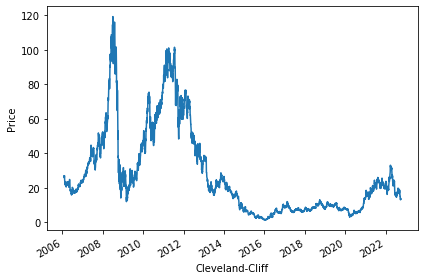

In [122]:
# Plot the time series
fig, ax = plt.subplots()

ax.plot(df.Date,df['PX_LAST'])
ax.set_xlabel(comp.Name[id])
ax.set_ylabel('Price')


fig.autofmt_xdate()
plt.tight_layout()

In [123]:
#Check for stationarity - ADF is not a large negative number and p-value is greater than 0.05
target = df['PX_LAST']
ADF_result = adfuller(target)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.149455684662609
p-value: 0.2250984995042462


In [124]:
#Take first difference and check for stationarity

df['PXdiff'] = target.diff()

ad_fuller_result = adfuller(df.PXdiff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.164580352374134
p-value: 7.356063544398727e-18


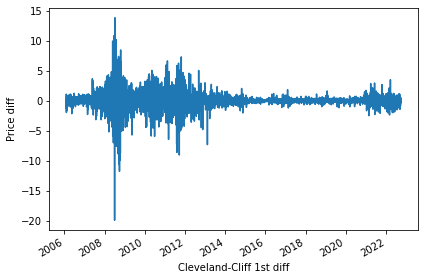

In [125]:
#Plot differenced series
fig, ax = plt.subplots()

ax.plot(df.Date,df.PXdiff)
ax.set_xlabel(comp.Name[id] + ' 1st diff')
ax.set_ylabel('Price diff')


fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
df.head()

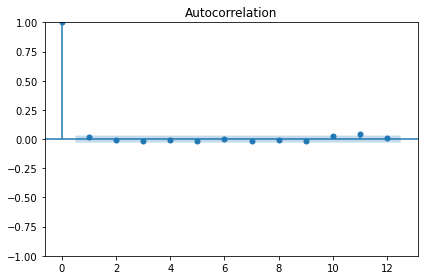

In [126]:
#Plot ACF for differenced series.
#df = df.dropna() #is it ok to drop NaN values
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.PXdiff[1:], lags=12); 
plt.tight_layout() #If there is NO AUTOCORRELATION - Is a random walk

In [127]:
df_diff = pd.DataFrame(df.PXdiff)

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

3777
420


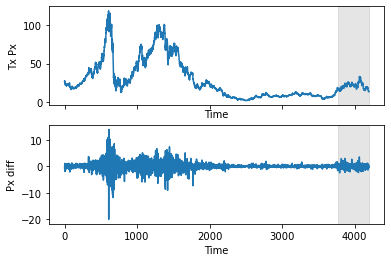

In [128]:
#Graph and highlight the test set

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['PX_LAST'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Tx Px')
ax1.axvspan(len(train), len(train)+len(test), color='#808080', alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Px diff')
ax2.axvspan(len(train), len(train)+len(test), color='#808080', alpha=0.2)

In [ ]:
#SINCE ALL SERIES SHOW NO AUTOCORRELATION AFTER TAKING FIRST DIFFERENCE, 

In [129]:
#Defining set of possible values for P and Q

ps = range(0, 5, 1)
qs = range(0, 5, 1)

order_list = list(product(ps, qs))
#order_list

In [130]:
#Optimizing ARMA process from convinations from 0 to 4 for P and Q

from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [131]:
#AIC results ordered by min to max. The lowest one is the best convination to fit ARMA(P,Q)

result_df = optimize_ARMA(df.PXdiff[1:], order_list)
result_df

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(4, 4)",15011.125194
1,"(3, 3)",15022.309707
2,"(2, 2)",15024.002723
3,"(2, 3)",15025.435755
4,"(4, 3)",15029.755715
5,"(3, 4)",15029.998477
6,"(0, 0)",15034.499093
7,"(0, 1)",15035.531942
8,"(1, 0)",15035.541760
9,"(2, 0)",15037.416101


In [132]:
# Model with lowest AIC : ARMA(4,4) - PERFORMING RESIDUAL ANALYSIS

model = SARIMAX(df.PXdiff, order=(4,0,4), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

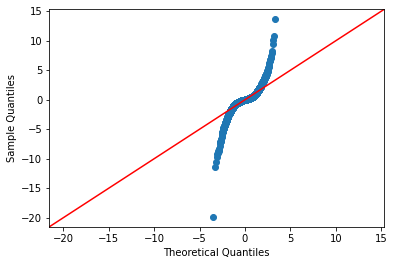

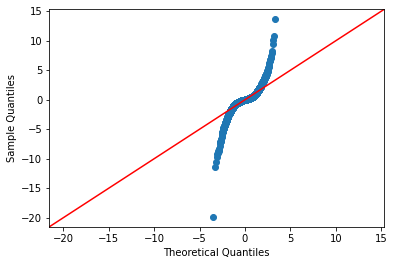

In [133]:
# PLOT RESIDUALS
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

In [ ]:
# def the models. Mean - Last Price - MA.
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':#NOT RUNNING
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [ ]:
#Save the results. Check what happened with the mean value.
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()
# Where is it calling PX_LAST to the differenced series. Why mean is not calculating? (Bc of NaN values on Dataset??)

In [ ]:
# Plot all results. Don't know why other results are not showing up

fig, ax = plt.subplots()

ax.plot(df_diff['PXdiff'])
ax.plot(pred_df['PXdiff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('PX_Last')

ax.axvspan(len(train), len(train)+30, color='#808080', alpha=0.2)

ax.set_xlim(len(train)-10, len(train)+30)



fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['PXdiff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['PXdiff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last)